In [1]:
# %pip install graphviz
from graphviz import Digraph
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x+5

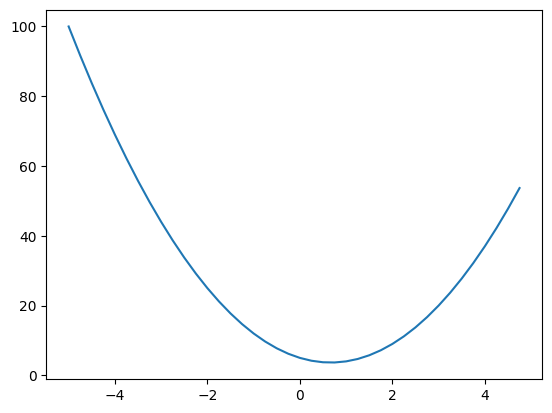

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

$$
f^{'}(a) = \lim_{h->0} \frac{f(a + h) - f(a)}{h}
$$

- 导数符号和 $f(a + h) - f(a)$ 一致。在a点导数为正（负），说明升（降）

In [4]:
# 体会上述代码的过程1.0
h = 0.00000001 # h不能设置的很大
a = 2/3 #2/3为0 ====> 为0说明对最后的结果没有作用，那么可以作为grad初始化
(f(a + h) - f(a)) / h

0.0

In [5]:
h = 0.0000001

b = 3.0
c = -2.0
d = 1

e1 = c * b + d

# e2的变量w加了h之后，可以看到该变量w对最后的e2的影响，这个影响即 d(e2)/d(w)
d += h # w += h (w = b,c,d)
e2 = c * b + d

print(e1)
print(e2)
print(e2 - e1) # 正负和最后导数正负一致，和h加到w上对e2的影响一致
print('slope', (e2 - e1) / h)

-5.0
-4.9999999
1.0000000028043132e-07
slope 1.0000000028043132


In [ ]:
class Value():
    def __init__(self, data=0.0, _children=(), _op="", label="") -> None:
        self.data = data
        self.grad = 0.0
        self.label = label
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        def _add_backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _add_backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        def _mul_backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _mul_backward

        return out

    def tanh(self):
        x = (np.exp(self.data*2) - 1) / (np.exp(self.data*2) + 1)
        out = Value(x, (self,), "tanh")
        def _tanh_backward():
            self.grad += out.grad * (1 - x**2)
        out._backward = _tanh_backward
        
        return out
    

    def backward(self):
        visited = set()
        topo = []
        def build_topo(u):
            visited.add(u)
            for v in u._prev:
                if v not in visited:
                    build_topo(v)
            topo.append(u)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()    

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label='e'
d = e + c;  d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
print((a * b)._prev, (a * b + c)._op, L) # same as (a.__mul__(b)).__add__(c)

{Value(data=-3.0), Value(data=2.0)} + Value(data=-8.0)


In [77]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{label %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot # ${workspaceFolder}/.env

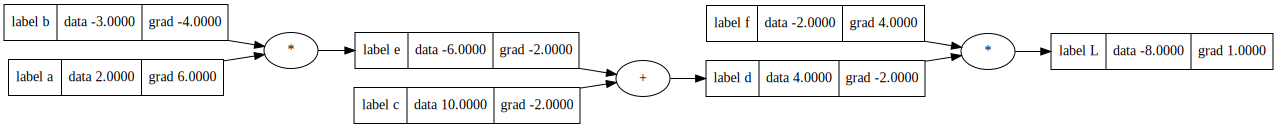

In [78]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0 # + 在图上就是让grad直接流过去,gradient distributor
c.grad = -2.0
a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)
draw_dot(L)

This function `lol` is called numerical derivetive check 
用于验证求导的正确性

上面的`x.grad`是指的 $\frac{\partial{\ell}}{\partial{x}}$


$\frac{\partial{\ell}}{\partial{d}} = f$


$\frac{\partial{\ell}}{\partial{f}} = d$


Intuitive thoughts from chain rule：

If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man.

if we know how c affect d, and we know how d affect L ==> we know how c affect L

In [79]:
def lol(): # 放到函数里面，局部变量，不会改变全局变量 ===> 
    h = 0.000001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label='e'
    d = e + c;  d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data # L 是Value class,所以要取data

    a = Value(2.0, label='a')
    a.data += h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label='e'
    d = e + c;  d.label='d'

    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1) / h)

lol() # 把h加到不同的变量上，就知道 相对L对该变量的导数是多少了

6.000000000838668


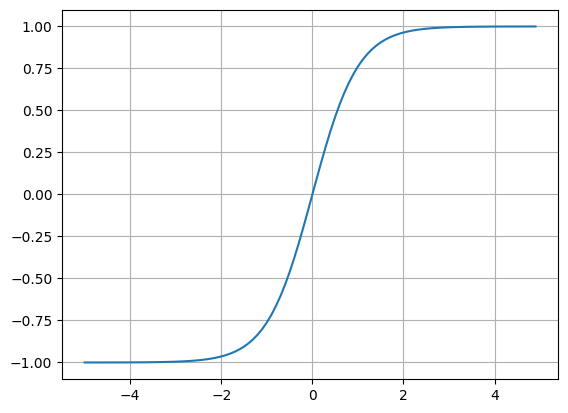

In [80]:
plt.plot(np.arange(-5, 5, 0.1), np.tanh(np.arange(-5, 5, 0.1))); plt.grid()

Next Step: imitate a neuron

In [124]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# w1.data += 0.000001
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
b = Value(6.8813735870195432, label='b')
y = x1w1 + x2w2 + b; y.label = 'y' 
print(y._prev)
tmp1, tmp2 = y._prev
print(tmp1._prev, tmp2._prev)
# 这里 我是对b的求和操作一起算了，但是加完之后会新创建一个Value，然后继续下一步
# 所以可视化出来永远是两个子节点，和一个op操作，不可能出现三个节点一起得到y的。是一个满二叉树

L = y.tanh()
L

{Value(data=6.881373587019543), Value(data=-6.0)}
set() {Value(data=0.0), Value(data=-6.0)}


Value(data=0.7071067811865476)

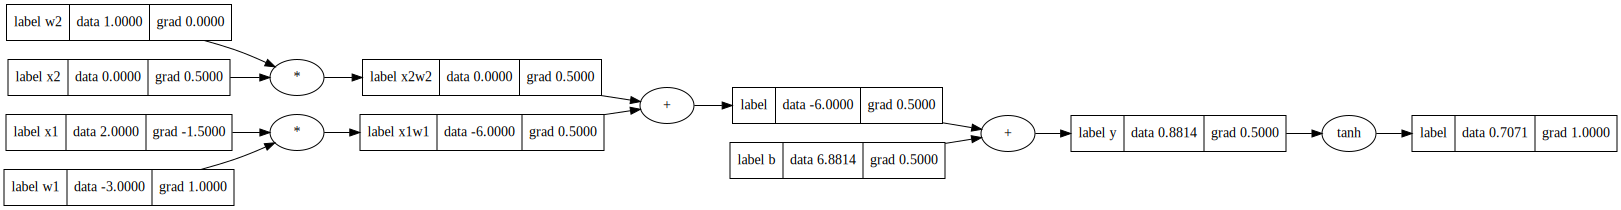

In [127]:
draw_dot(L)

In [84]:
# 手动调gradient
L.grad = 1.0
# L = tanh(y)
# dtanh(x)/dx = 1 - tanh(x)**2
y.grad = 1.0 - L.data**2
b.grad = 0.5 # 加法是gradient distributer
# 中间变量我们没法手动给出了,但某种角度来说我们也不care,我们只care叶子节点，中间过程 blind to it
x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = x2w2.grad * w2.data
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data

In [92]:
# 自动求gradient
L.grad = 1.0
L._backward(); print(L._backward.__name__)
y._backward(); print(y._backward.__name__)
b._backward(); print(b._backward.__name__)

# 到这一步后面我们发现没法"显示"调用了，因为我们并没有给中间变量命名，不过，他存在_prev里面，我们可以通过遍历set（无序，无法用下标访问）来调用其_backward函数
print(y._prev)
for element in y._prev:
    element._backward(); print(element._backward.__name__)
    
# 通过这个过程 ==> 我们可以自动化这个过程，结合拓扑序

_tanh_backward
_add_backward
<lambda>
{Value(data=6.881373587019543), Value(data=-6.0)}
<lambda>
_add_backward


拓扑序实现自动求导
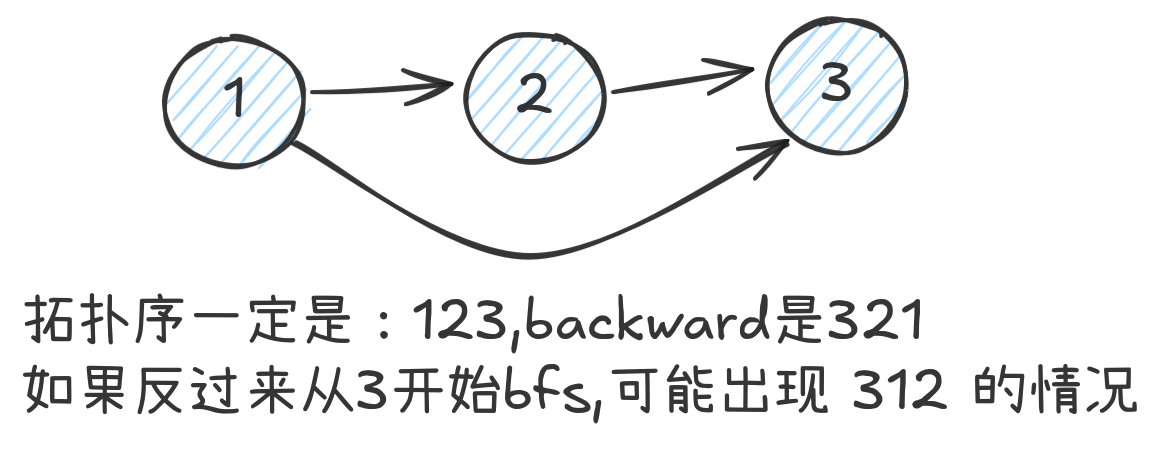

In [ ]:
# bfs 写法，不用reverse, bfs顺序就是backward的顺序。（但发现是不对的，改为下面这一版）
def autograd(out):
    out.grad = 1.0
    chain = []
    visited = set()
    topo = []
    topo.append(out)
    chain.append(out)
    while len(topo):
        top = topo.pop(0)
        if top in visited:
            continue
        visited.add(top)
        for element in top._prev:
            topo.append(element)
            chain.append(element) # 这里后面出现了bug, 因为可能会出现两个父节点同时指向一个子节点的特殊情况。
            # 这样在chain里面就执行了两次backward从而累计了两次梯度。
    for i in chain:
        print(i, i._backward.__name__)  
        i._backward()  

# 改成下面这一版后发现也不对
#正确的bfs写法 --> 也不正确 -> BFS是不行的，因为无法保证：当前节点的前面所有节点都已经经过backward
def backward(self):
    self.grad = 1.0
    visited = set()
    topo = []
    topo.append(self)
    while len(topo):
        top = topo.pop(0)
        # print(top.label, top._backward.__name__)
        top._backward()
        for element in top._prev:
            if element in visited:
                continue
            visited.add(element)
            topo.append(element)

autograd(L)
# ==> 写好这个代码，下一步是要封装到class里面

Value(data=0.7071067811865476) _tanh_backward
Value(data=0.8813735870195432) _add_backward
Value(data=-6.0) _add_backward
Value(data=6.881373587019543) <lambda>
Value(data=-6.0) _mul_backward
Value(data=0.0) _mul_backward
Value(data=2.0) <lambda>
Value(data=-3.0) <lambda>
Value(data=0.0) <lambda>
Value(data=1.0) <lambda>


In [126]:
L.backward()